In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader

from sklearn import metrics
from sklearn.metrics import roc_curve, auc


In [8]:
# Define device
device = torch.device("cpu")


In [9]:
# Define transformations for the training and test sets
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [10]:
# Load datasets
train_dataset = datasets.ImageFolder(root='train/', transform=transform)
val_dataset = datasets.ImageFolder(root='test/', transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)

In [11]:
# Load the VGG16 model pre-trained on ImageNet
model = models.vgg16(pretrained=True)

# Modify the classifier to match the number of classes in the dataset
num_classes = 2
model.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)

# Move the model to the device
model = model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [12]:
# Training 
import time

num_epochs = 10
loss_per_epoch = []
start_1 = time.time()

model.train()
for epoch in range(num_epochs):
    running_loss = 0.0
    start_2 = time.time()
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
    end_2 = time.time()
    print(f'Time taken for {epoch} is {end_2 - start_2}')
    epoch_loss = running_loss / len(train_loader.dataset)
    loss_per_epoch.append(epoch_loss)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")
end_1 = time.time()
print(f'Total time take to run {num_epochs} epochs: {end_1 - start_1}')


Time taken for 0 is 3311.663717985153
Epoch 1/10, Loss: 0.3047
Time taken for 1 is 3385.8493196964264
Epoch 2/10, Loss: 0.2395


KeyboardInterrupt: 

In [16]:
# Evaluation
model.eval()
val_loss = 0.0
correct = 0
total = 0
actual = []
pred = []
all_labels = []
all_probs = []
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        val_loss += loss.item() * inputs.size(0)
        probs = nn.functional.softmax(outputs, dim=1)
        _, predicted = torch.max(outputs, 1)
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())
        correct += torch.sum(predicted == labels)
        for i in labels:
            actual.append(i)
        for x in predicted:
            pred.append(x)

val_loss /= len(val_loader.dataset)
accuracy = correct.double() / len(val_loader.dataset)
print(f"Validation Loss: {val_loss:.4f}, Accuracy: {accuracy:.4f}")

Validation Loss: 0.2063, Accuracy: 0.9285


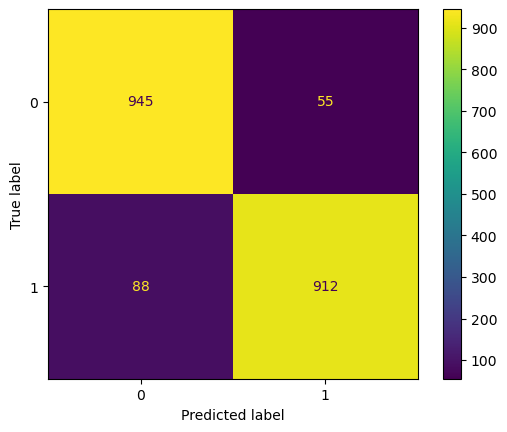

In [17]:
conf_mat = metrics.confusion_matrix(actual, pred)
display_plot = metrics.ConfusionMatrixDisplay(confusion_matrix = conf_mat, display_labels = [0,1])
display_plot.plot()
plt.show()

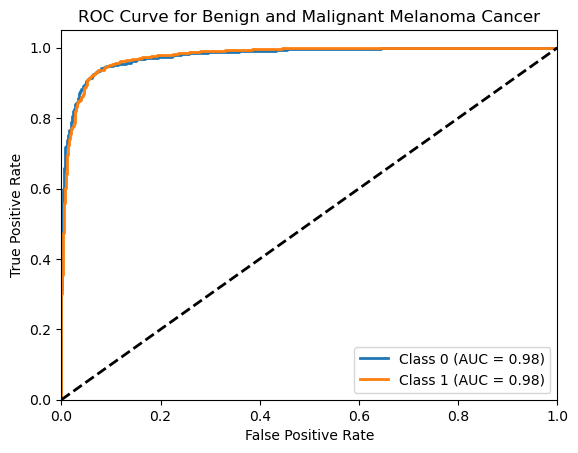

In [18]:
all_labels = np.array(all_labels)
all_probs = np.array(all_probs)

fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = 2
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(all_labels == i, all_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class

for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Benign and Malignant Melanoma Cancer')
plt.legend(loc="lower right")
plt.show()

In [19]:
final_pred = pd.DataFrame({'actual':actual,'pred':pred})
final_pred.to_csv('preds_vgg.csv')

final_prob = pd.DataFrame(all_probs, columns=[f'Class_{i}' for i in range(all_probs.shape[1])])
final_prob['all_labels'] = all_labels
final_prob.to_csv('probs_vgg.csv')
